# Map between two states and get free energy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.7

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.7


In [3]:
import jax
import equinox as eqx
import logging
import git
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp
from dataclasses import asdict
from typing import cast

from rigid_flows.data import DataWithAuxiliary
from rigid_flows.density import KeyArray, OpenMMDensity
from rigid_flows.flow import (
    RigidWithAuxiliary,
    build_flow,
    initialize_actnorm,
    toggle_layer_stack,
)
from rigid_flows.reporting import Reporter, pretty_json
from rigid_flows.specs import ExperimentSpecification
from rigid_flows.train import run_training_stage

from flox._src.flow.api import Transform
from flox.flow import Pipe
from flox.util import key_chain


2023-01-19 14:22:36.811082: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-19 14:22:36.811182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-19 14:22:36.811190: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
logging.getLogger().setLevel(logging.INFO)

def setup_model(key: KeyArray, specs: ExperimentSpecification, selection: slice = np.s_[:]):
    chain = key_chain(key)

    logging.info("Loading base density.")
    base = OpenMMDensity.from_specs(
        specs.model.auxiliary_shape, specs.model.base, selection
    )

    logging.info(f"Loading target density.")
    target = OpenMMDensity.from_specs(
        specs.model.auxiliary_shape, specs.model.target, selection
    )

    logging.info(f"Setting up flow model.")
    flow = build_flow(
        next(chain),
        specs.model.auxiliary_shape,
        specs.model.flow,
        # base,
        # target,
    )

    logging.info(f"Initializing ActNorm")

    @eqx.filter_jit
    def init_actnorm(flow, key):
        actnorm_batch = jax.vmap(target.sample)(
            jax.random.split(key, specs.act_norm_init_samples)
        ).obj
        flow = toggle_layer_stack(flow, False)
        flow, _ = initialize_actnorm(flow, actnorm_batch)
        flow = toggle_layer_stack(flow, True)
        return flow

    flow = init_actnorm(flow, next(chain))

    if specs.model.pretrained_model_path is not None:
        logging.info(
            f"Loading pre-trained model from {specs.model.pretrained_model_path}."
        )
        flow = cast(
            Pipe[DataWithAuxiliary, RigidWithAuxiliary],
            eqx.tree_deserialise_leaves(
                specs.model.pretrained_model_path, flow
            ),
        )

    return base, target, flow


def train(
    key: KeyArray,
    run_dir: str,
    specs: ExperimentSpecification,
    base: OpenMMDensity,
    target: OpenMMDensity,
    flow: Transform[DataWithAuxiliary, DataWithAuxiliary],
    tot_iter: int,
    loss_reporter: list | None = None,
) -> Transform[DataWithAuxiliary, DataWithAuxiliary]:
    chain = key_chain(key)
    repo = git.Repo(search_parent_directories=True)
    branch = repo.active_branch.name
    sha = repo.head.object.hexsha

    log = asdict(specs)
    log["git"] = {"branch": branch, "sha": sha}
    # tf.summary.text("run_params", pretty_json(log), step=tot_iter)
    logging.info(f"Starting training.")
    reporter = Reporter(
        base,
        target,
        run_dir,
        specs.reporting,
        scope=None,
    )
    reporter.with_scope(f"initial").report_model(next(chain), flow, tot_iter)
    for stage, train_spec in enumerate(specs.train):
        flow = run_training_stage(
            next(chain),
            base,
            target,
            flow,
            train_spec,
            specs.model.target,
            reporter.with_scope(f"training_stage_{stage}"),
            tot_iter,
            loss_reporter,
        )
        tot_iter += train_spec.num_iterations
    return flow

def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}

In [34]:
reference_deltaF = -664.56
reference_deltaF_std = 0.03

In [6]:
specs_file = "testing.yaml"
specs = ExperimentSpecification.load_from_file(specs_file)

num_datapoints = 10_000
chain = key_chain(specs.seed)
base, target, flow = setup_model(next(chain), specs, np.s_[:num_datapoints])
model = base.omm_model.model

tot_iter = specs.global_step if specs.global_step is not None else 0

print(f'tot flow parameters: {count_params(flow):_}')

INFO:root:Loading base density.
INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T250_N16.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T250_N16.npz
INFO:root:Loading target density.
INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T100_N16.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T100_N16.npz
INFO:root:Setting up flow model.
INFO:root:Initializing ActNorm


tot flow parameters: 487_680


In [7]:
num_samples = 1_000

keys = jax.random.split(next(chain), num_samples)
base_tr = jax.vmap(base.sample)(keys)

mapped_tr = jax.vmap(flow.inverse)(base_tr.obj)

keys = jax.random.split(next(chain), num_samples)
target_tr = jax.vmap(target.sample)(keys)

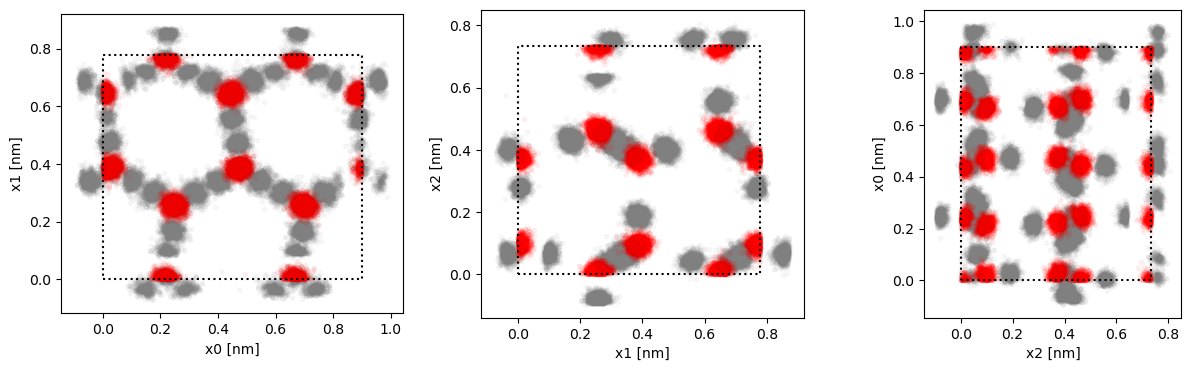

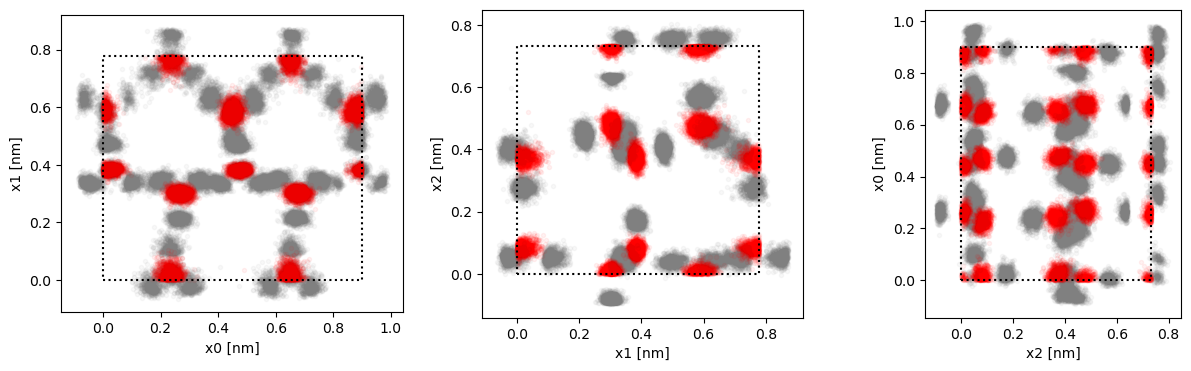

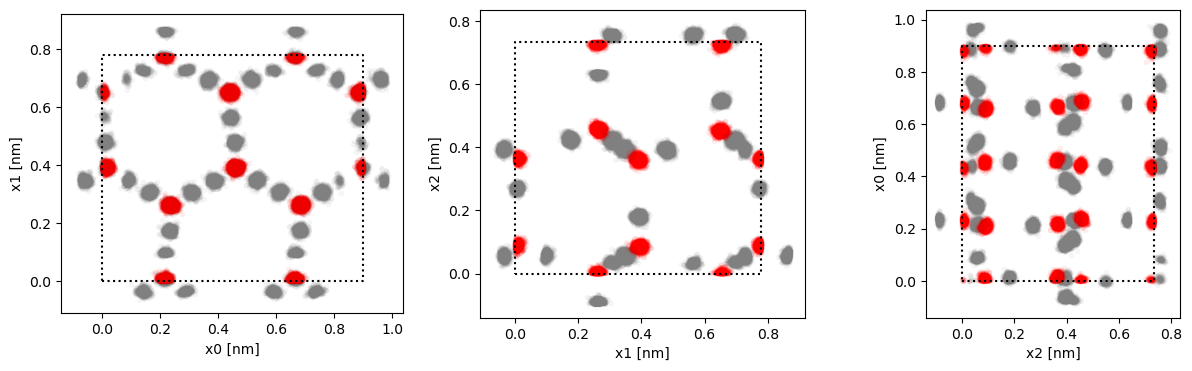

In [8]:
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))


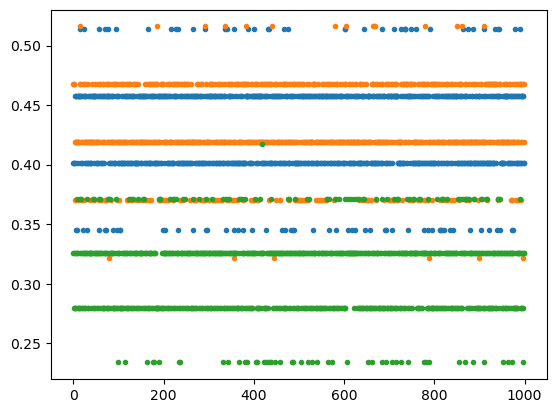

In [9]:
## closer look at the center of mass
com_pos = base_tr.obj.pos.mean(axis=(1,2))
plt.plot(com_pos, '.')
plt.show()

In [10]:
%%time

loss_reporter = []
flow = train(next(chain), "testing", specs, base, target, flow, tot_iter, loss_reporter)

INFO:root:Starting training.
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/initial
Epoch: 1/2: 100%|██████████| 1000/1000 [03:58<00:00,  4.19it/s, loss=-648.5671] 
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_0
Epoch: 2/2: 100%|██████████| 1000/1000 [03:07<00:00,  5.35it/s, loss=-654.2833]
INFO:root:preparing report
INFO:root:sampling from data
INFO:root:sampling from prior
INFO:root:sampling from model
INFO:root:Saving artifacts to testing/training_stage_0/epoch_1


CPU times: user 8min 59s, sys: 1min 15s, total: 10min 14s
Wall time: 8min 5s


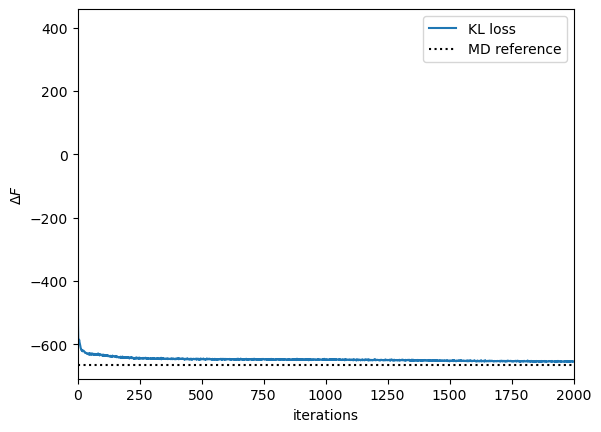

In [11]:
plt.plot(loss_reporter, label='KL loss')
plt.axhline(reference_deltaF, c="k", ls=":", label='MD reference')
plt.xlim(0, len(loss_reporter))
plt.xlabel('iterations')
plt.ylabel('$\Delta F$')
plt.legend()
plt.show()

In [12]:
mapped_tr = jax.vmap(flow.inverse)(base_tr.obj)


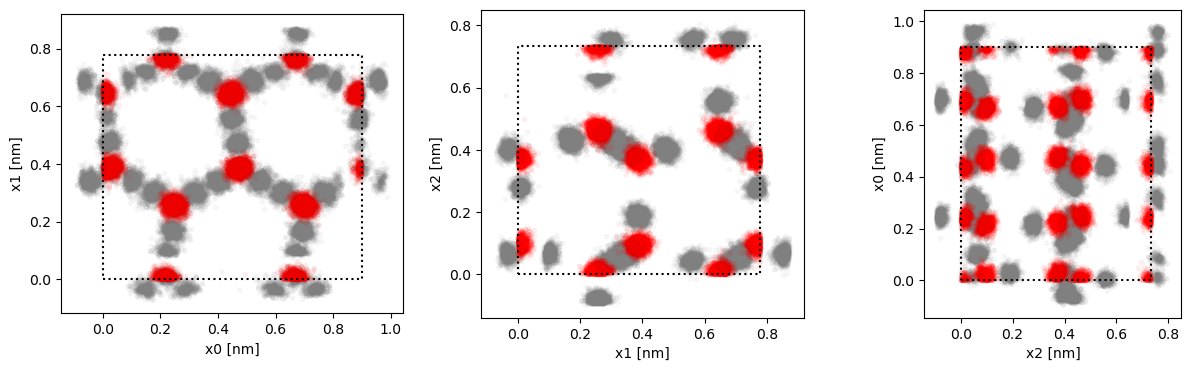

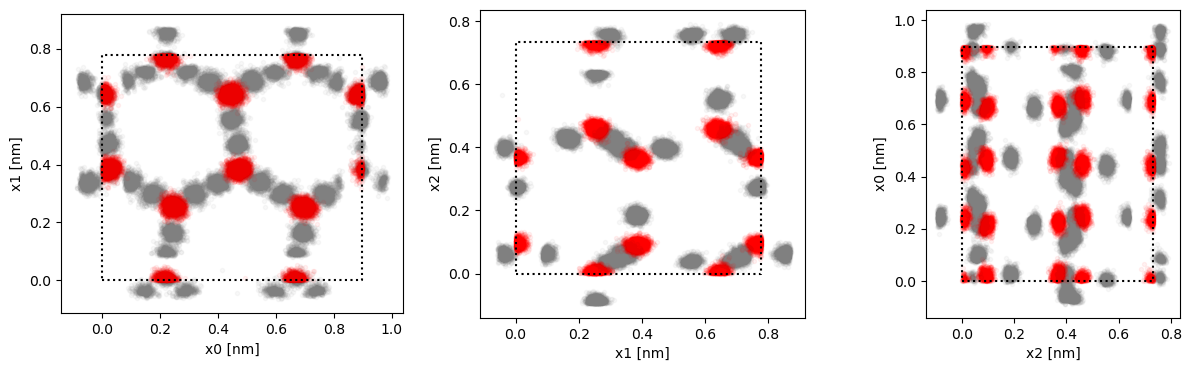

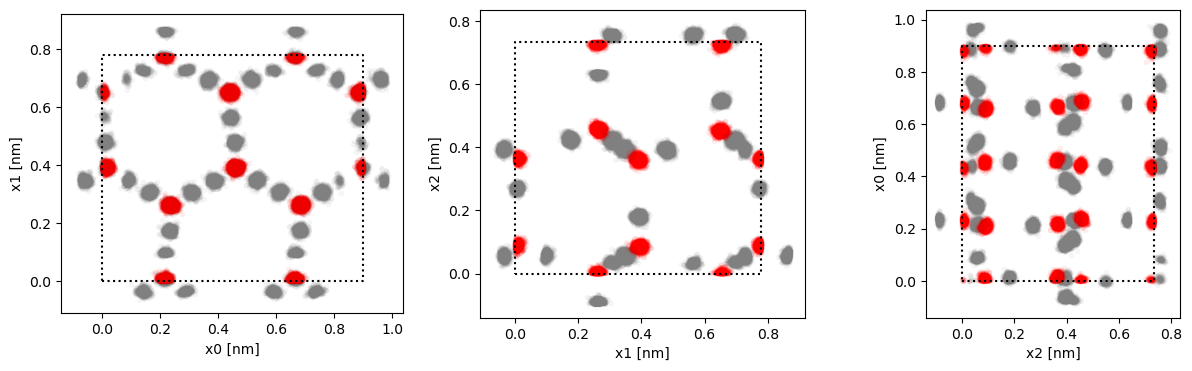

In [13]:
model.plot_2Dview(base_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3))
model.plot_2Dview(target_tr.obj.pos.reshape(-1, model.n_atoms, 3))


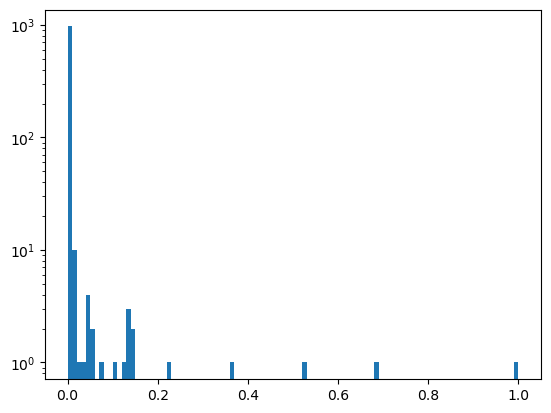

ESS = 9.68905  ->  0.97%


In [14]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')

In [15]:
ene_fn = jax.vmap(target.potential)
base_ene = ene_fn(base_tr.obj)
mapped_ene = ene_fn(mapped_tr.obj)
target_ene = ene_fn(target_tr.obj)

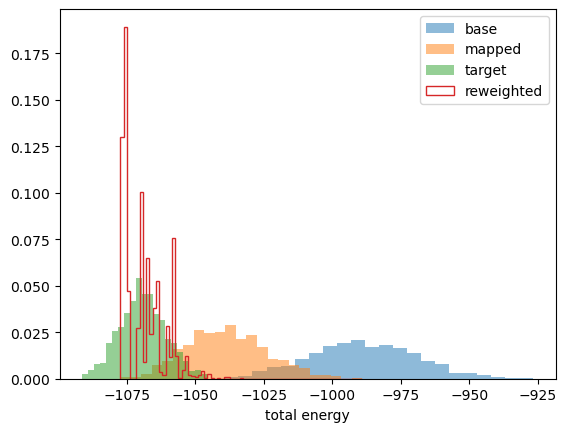

In [16]:
plt.hist(base_ene, **hist_kwargs, label='base')
plt.hist(mapped_ene, **hist_kwargs, label='mapped')
plt.hist(target_ene, **hist_kwargs, label='target')
plt.hist(mapped_ene, weights=np.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel('total energy')
plt.legend()
plt.show()

In [17]:
ene_label = 'omm'
base_ene2 = target.compute_energies(base_tr.obj, True, True, True)[ene_label]
target_ene2 = target.compute_energies(target_tr.obj, True, True, True)[ene_label]
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, True, True)[ene_label]

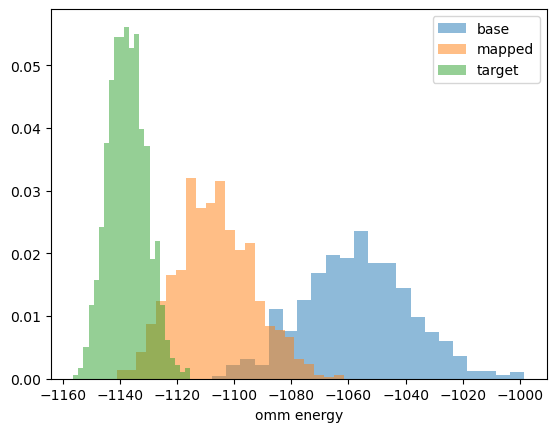

In [18]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.xlabel(ene_label + ' energy')
plt.legend()
plt.show()

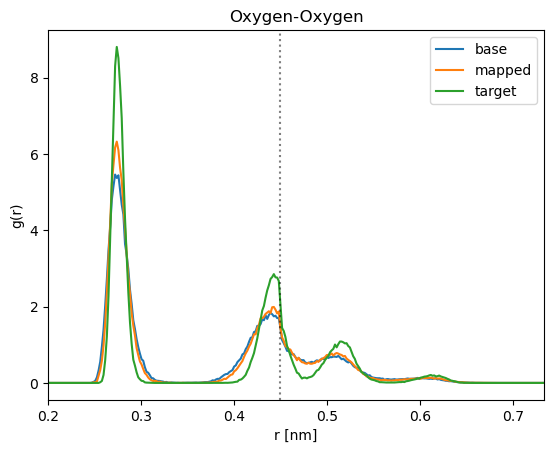

In [19]:
r_range = [0.2, np.diag(model.box).min()]
n_bins = 300
plt.title('Oxygen-Oxygen')
model.plot_rdf(base_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='base')
model.plot_rdf(mapped_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='mapped')
model.plot_rdf(target_tr.obj.pos.reshape(-1, model.n_atoms, 3), r_range=r_range, n_bins=n_bins, label='target')
plt.axvline(model.box.max()/2, c='k', ls=':', alpha=.5)
plt.legend()
plt.show()

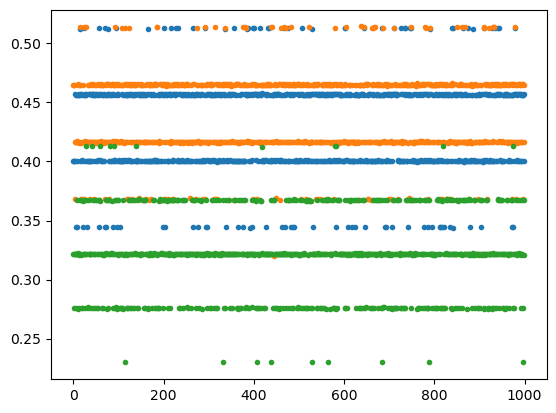

In [20]:
## closer look at the center of mass
com_pos = mapped_tr.obj.pos.mean(axis=(1,2))
# com_pos = base_tr.obj.pos.mean(axis=(1,2)) - mapped_tr.obj.pos.mean(axis=(1,2))
plt.plot(com_pos, '.')
plt.show()
# for i in range(3):
#     plt.hist(com_pos[:,i], **hist_kwargs)
# plt.show()

In [21]:
## TFEP
deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from TFEP = {deltaF:g}')
print(f'          Reference deltaF = {reference_deltaF:g}')

Estimated deltaF from TFEP = -664.963
          Reference deltaF = -664.56


In [22]:
def estimate_deltaF(key, num_samples, base):
    keys = jax.random.split(key, num_samples)
    base_tr = jax.vmap(base.sample)(keys)
    mapped_tr = jax.vmap(flow.inverse)(base_tr.obj)
    logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)
    return (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()

eval_base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base, np.s_[-num_datapoints:])
eval_base.data.pos.shape[0]

INFO:root:Loading OpenMM model specs from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/model-iceXI_T250_N16.json
INFO:root:Loading data from /group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/MDtraj-iceXI_T250_N16.npz


10000

In [23]:
estimate_from_training = False #this gives a biased estimate, always lower

from tqdm import trange

#NB: it's maybe better to use all MD points instead of randomly samplinging
iterations = 10
n_samples = 1000 

if estimate_from_training:
    deltaFs = np.zeros(iterations)
    for i in trange(iterations):
        deltaFs[i] = estimate_deltaF(next(chain), n_samples, base)
    print(f'deltaF = {deltaFs.mean():g} +/- {deltaFs.std():g}')

eval_deltaFs = np.zeros(iterations)
for i in trange(iterations):
    eval_deltaFs[i] = estimate_deltaF(next(chain), n_samples, eval_base)
eval_deltaFs.mean(), eval_deltaFs.std()
print(f'deltaF = {eval_deltaFs.mean():g} +/- {eval_deltaFs.std():g}')

100%|██████████| 10/10 [02:01<00:00, 12.13s/it]

deltaF = -664.923 +/- 0.448417


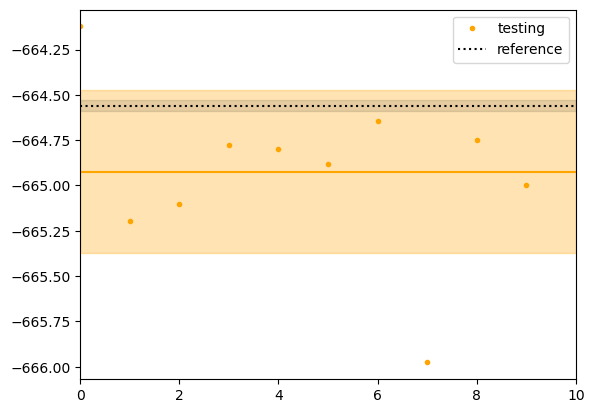

In [36]:
xlim = [0, len(eval_deltaFs)]
if estimate_from_training:
    plt.plot(deltaFs, '.', c='blue', label='training')
    x = 2 * [deltaFs.mean()]
    plt.fill_between(xlim, x-deltaFs.std(), x+deltaFs.std(), color='blue', alpha=0.3)
    plt.axhline(deltaFs.mean(), c='blue')
plt.plot(eval_deltaFs, '.', c='orange', label='testing')
x = 2 * [eval_deltaFs.mean()]
plt.fill_between(xlim, x-eval_deltaFs.std(), x+eval_deltaFs.std(), color='orange', alpha=0.3)
plt.axhline(eval_deltaFs.mean(), c='orange')
plt.axhline(reference_deltaF, c='k', ls=":", label='reference')
x = np.array(2 * [reference_deltaF])
plt.fill_between(xlim, x-reference_deltaF_std, x+reference_deltaF_std, color='k', alpha=0.1)
plt.xlim(xlim)
plt.legend()
plt.show()